In [18]:
import pandas as pd
import numpy as np
import random as rd
import os
import random as rd
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler




In [19]:
df = pd.read_csv("ckextended.csv")

In [20]:
emotions = ['Anger', "Disgust", "Fear", "Happy", "Sadness", "Surprise", "Neutral"]  # Emoções do CK+
data_path = "ckextended.csv" 
emotion_data = {}
emotion_pcas = {}

In [21]:
df.value_counts("emotion").sort_index()

emotion
0     45
1     59
2     25
3     69
4     28
5     83
6    593
7     18
Name: count, dtype: int64

In [22]:
df["pixels"][0]

'36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 101 107 111 117 122 127 127 130 135 140 138 132 125 108 95 93 69 43 26 18 14 13 7 3 8 21 26 6 4 20 38 20 38 36 41 20 19 9 8 13 11 10 5 23 56 84 97 113 115 111 113 120 126 131 130 137 139 140 141 140 132 119 111 99 88 76 47 22 7 7 8 6 3 5 12 18 4 15 24 55 39 37 41 26 14 11 15 11 14 9 10 43 69 92 106 108 114 121 125 126 127 131 134 131 134 143 147 147 140 129 127 123 115 98 72 47 26 14 8 9 14 3 14 16 21 9 12 49 39 39 40 24 18 15 10 20 17 13 41 63 78 98 105 106 123 124 125 126 133 134 133 137 140 138 142 141 135 133 130 123 119 115 95 69 47 41 22 19 12 19 7 17 31 30 20 32 33 35 39 23 16 13 22 19 13 34 61 69 84 87 98 114 113 117 122 129 132 132 135 134 138 143 142 141 138 132 129 126 122 116 104 84 55 45 31 12 22 16 11 8 13 32 24 17 33 33 34 19 15 19 20 11 26 54 70 76 83 93 98 104 110 118 120 120 127 126 127 130 131 126 131 131 123 122 115 117 110 112 107 99 84 61 51 30 17 7 39 23 22 16 53 8 37 38 35 22 23 23 3 12 41 68 77 81 84 90 94 96 112 118

**FUNÇÕES IMPORTANTES**

In [59]:
def training_PCA(faces_flatten, df_flatten, target_index, N_COMPONENTS=30):
    emotion_data = {}
    emotion_pcas = {}

    target_img = faces_flatten[target_index]
    scaler = StandardScaler()  # Para normalização

    min_samples = min([
    df_flatten[df_flatten["emotion"] == e].shape[0]
    for e in emotions
    ])

    # 2) usa esse valor como limite global
    GLOBAL_N_COMPONENTS = min(N_COMPONENTS, min_samples - 1)

    print("GLOBAL N_COMPONENTS =", GLOBAL_N_COMPONENTS)

    for emotion in emotions:

        data = df_flatten[df_flatten["emotion"] == emotion]["pixels"]
        if data.shape[0] == 0:
            continue

        X_train = np.vstack(data).astype(np.float32)
        X_train = scaler.fit_transform(X_train)

        emotion_indices = data.index.values
        target_row = target_index
        if target_row in emotion_indices:
            data = data.drop(target_row)      # Evita overfitting.
 
        X_train = np.vstack(data.values).astype(np.float32)

        emotion_data[emotion] = {'train': X_train}

        print("Treinando", emotion, "com shape:", X_train.shape)

        if X_train.shape[0] < 2:
            print("Amostras insuficientes, pulando", emotion)
            continue

        training_samples = min(X_train.shape[0], N_COMPONENTS)
        pca = PCA(n_components=GLOBAL_N_COMPONENTS).fit(X_train)
        emotion_pcas[emotion] = pca

    return emotion_data, emotion_pcas

**Essa é função mais importante do projeto**

In [24]:
def classify_emotion(faces_flatten, emotion_pcas, target_index):
    min_error = float('inf')
    predicted_emotion = None
    target_image = faces_flatten[target_index]

    # Projetar a imagem-alvo em cada PCA gerado pelo X_Train de um emoção específica
    for emotion, pca in emotion_pcas.items():
        
        # Projetamos a imagem alvo no espaço gerado pelo PCA daquela emoção
        projection = pca.transform([target_image])

        # Reconstruir a imagem usando aquela fórmula A1 = B @ C.T
        reconstruction = pca.inverse_transform(projection).flatten()      

        # Calcula erro quadrático |A - A1|²
        error = mean_squared_error(target_image, reconstruction)

        if error < min_error:
            min_error = error
            predicted_emotion = emotion

    return predicted_emotion, min_error

In [25]:
def process_pixels(pixel_str):
    try:
        pixels = np.array(pixel_str.split(), dtype=np.uint8)
        if len(pixels) == 2304:  # Verifica tamanho exato
            return pixels.reshape(2304,-1) # deixa imagens em flatten
        else:
            return None  # Marca como inválido
    except (ValueError, TypeError):
        return None  # Trata erros (e.g., string vazia)

**LIMPEZA E NORMALIZAÇÃO**

In [ ]:
df = df.sort_values(by="emotion").reset_index(drop=True)
df_flatten = df.copy()
df_flatten["pixels"] = df["pixels"].apply(lambda x: process_pixels(x).flatten())
df_flatten["pixels"][0]  # Imagens estão em vetores verticais ;)

array([34, 26, 15, ...,  3, 60, 39], shape=(2304,), dtype=uint8)

In [27]:
faces = df["pixels"].apply(lambda x: process_pixels(x).reshape(48, 48))
faces_flatten = df["pixels"].apply(lambda x: process_pixels(x).flatten())

In [28]:
lenghts = df.groupby("emotion").count()["pixels"].to_list() # Pega a quantidade de imagens para cada emoção
begin = df.groupby("emotion").head(1).index.to_list() # Pega a primeira ocorrência de cada emoção
begin, lenghts

([0, 45, 104, 129, 198, 226, 309, 902], [45, 59, 25, 69, 28, 83, 593, 18])

**Aqui fiz uma substituição dos indexes que indicavam emoções por string que facilitam a visualização**

In [29]:
df_flatten["emotion"] = df_flatten["emotion"].replace({
    0: "Anger",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sadness",
    5: "Surprise",
    6: "Neutral"
})

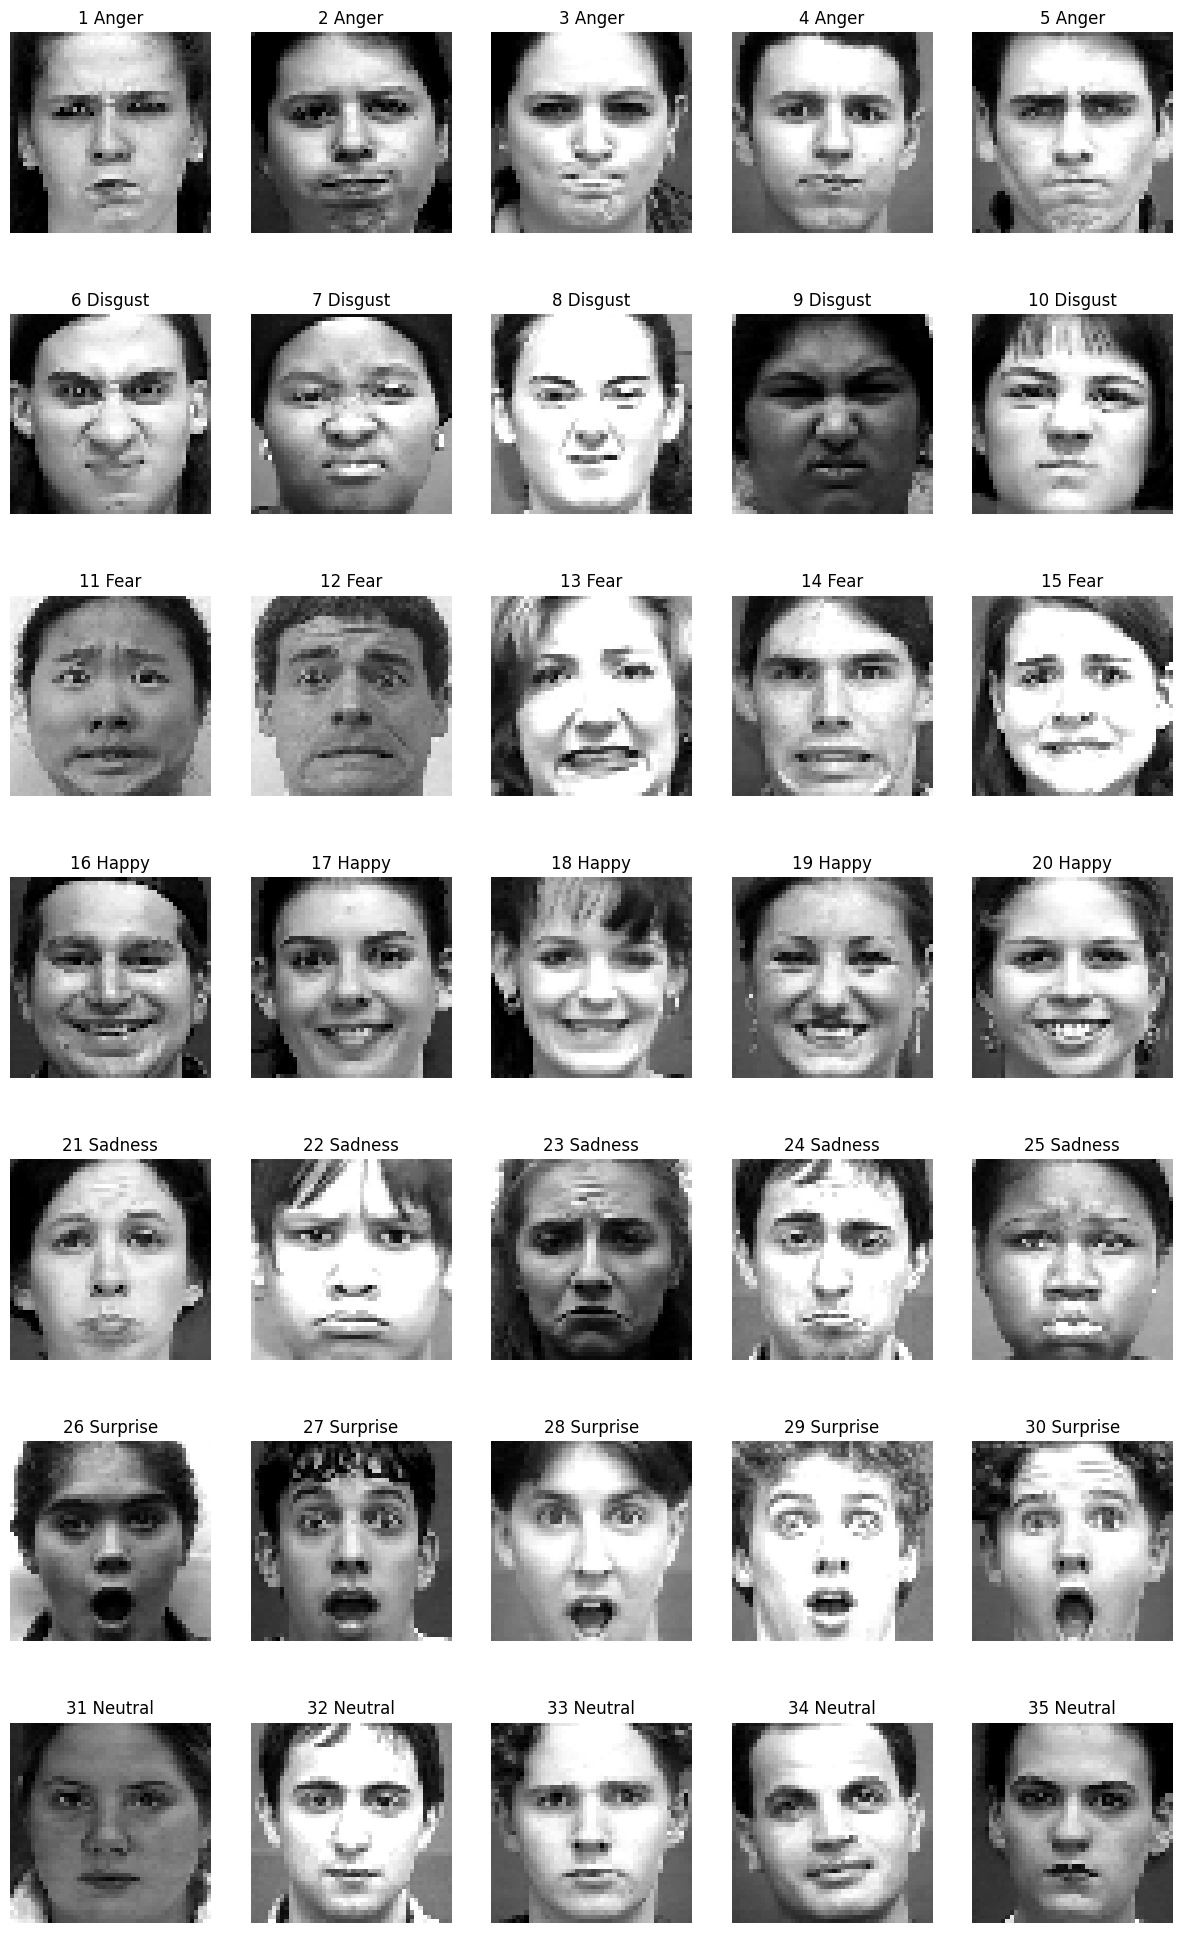

In [30]:
plt.figure(figsize=(15, 25))
k = 0
for i in range(7):
    for j in range(5):
        img = faces[begin[i] + j]
        expression  = df_flatten.loc[begin[i] + j]["emotion"]        
        idx = i*5 + j +1
        plt.subplot(7, 5, idx) 
        plt.imshow(img, cmap="gray")
        plt.title(f"{idx} {expression}", fontsize=12)
        plt.axis("off")
plt.show()

In [31]:
for i in range(7):
    print(f"{begin[i]:>3}   =>  {(begin[i+1]-1):>3}  =>  {emotions[i]}")

  0   =>   44  =>  Anger
 45   =>  103  =>  Disgust
104   =>  128  =>  Fear
129   =>  197  =>  Happy
198   =>  225  =>  Sadness
226   =>  308  =>  Surprise
309   =>  901  =>  Neutral


**Escolha o index que quer verificar**

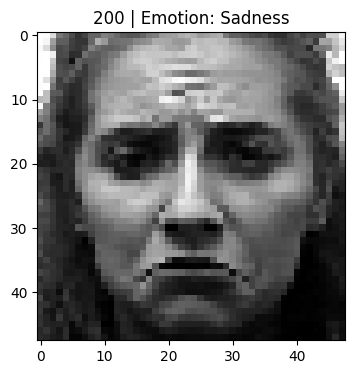

In [67]:
target_index = 200

# IMAGEM ORIGINAL
face = faces[target_index]
emotion = df_flatten.loc[target_index]["emotion"]
plt.figure(figsize=(4, 4))
plt.title(f"{target_index} | Emotion: {emotion}")
plt.imshow(face, cmap='gray')
#plt.axis("off")
plt.show()

In [83]:
data, pcas = training_PCA(faces_flatten, df_flatten, target_index, 30)
detected_emotion, min_error = classify_emotion(faces_flatten, pcas, target_index)

print(detected_emotion, float(min_error))

GLOBAL N_COMPONENTS = 24
Treinando Anger com shape: (45, 2304)
Treinando Disgust com shape: (59, 2304)
Treinando Fear com shape: (25, 2304)
Treinando Happy com shape: (69, 2304)
Treinando Sadness com shape: (27, 2304)
Treinando Surprise com shape: (83, 2304)
Treinando Neutral com shape: (593, 2304)
Neutral 536.2031553370717
